In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas

# Analyse du risque de défaillance des joints toriques de la navette Challenger

Le 27 Janvier 1986, veille du décollage de la navette *Challenger*, eu
lieu une télé-conférence de trois heures entre les ingénieurs de la
Morton Thiokol (constructeur d'un des moteurs) et de la NASA. La
discussion portait principalement sur les conséquences de la
température prévue au moment du décollage de 31°F (juste en dessous de
0°C) sur le succès du vol et en particulier sur la performance des
joints toriques utilisés dans les moteurs. En effet, aucun test
n'avait été effectué à cette température.

L'étude qui suit reprend donc une partie des analyses effectuées cette
nuit là et dont l'objectif était d'évaluer l'influence potentielle de
la température et de la pression à laquelle sont soumis les joints
toriques sur leur probabilité de dysfonctionnement. Pour cela, nous
disposons des résultats des expériences réalisées par les ingénieurs
de la NASA durant les 6 années précédant le lancement de la navette
Challenger.



## Chargement des données
Nous commençons donc par charger ces données:

In [2]:
data = pd.read_csv("shuttle.csv")
data

Date  Count  Temperature  Pressure  Malfunction
0    4/12/81      6           66        50            0
1   11/12/81      6           70        50            1
2    3/22/82      6           69        50            0
3   11/11/82      6           68        50            0
4    4/04/83      6           67        50            0
5    6/18/82      6           72        50            0
6    8/30/83      6           73       100            0
7   11/28/83      6           70       100            0
8    2/03/84      6           57       200            1
9    4/06/84      6           63       200            1
10   8/30/84      6           70       200            1
11  10/05/84      6           78       200            0
12  11/08/84      6           67       200            0
13   1/24/85      6           53       200            2
14   4/12/85      6           67       200            0
15   4/29/85      6           75       200            0
16   6/17/85      6           70       200            0
17   7/29/85      6           81       200            0
18   8/27/85      6           76       200            0
19  10/03/85      6           79       200            0
20  10/30/85      6           75       200            2
21  11/26/85      6           76       200            0
22   1/12/86      6           58       200            1

Le jeu de données nous indique la date de l'essai, le nombre de joints
toriques mesurés (il y en a 6 sur le lançeur principal), la
température (en Farenheit) et la pression (en psi), et enfin le
nombre de dysfonctionnements relevés. 

## Inspection graphique des données
~~Les vols où aucun incident n'est relevé n'apportant aucun information
sur l'influence de la température ou de la pression sur les
dysfonctionnements, nous nous concentrons sur les expériences où au
moins un joint a été défectueux.~~

**Faux ! Le fait qu'aucun incident soit arrivé est au contraire une information très importante.**

In [3]:
real_data = data
real_data["MalfunctionHappen"] = real_data['Malfunction'].apply(lambda x: 1 if x > 0 else 0)
real_data

Date  Count  Temperature  Pressure  Malfunction  MalfunctionHappen
0    4/12/81      6           66        50            0                  0
1   11/12/81      6           70        50            1                  1
2    3/22/82      6           69        50            0                  0
3   11/11/82      6           68        50            0                  0
4    4/04/83      6           67        50            0                  0
5    6/18/82      6           72        50            0                  0
6    8/30/83      6           73       100            0                  0
7   11/28/83      6           70       100            0                  0
8    2/03/84      6           57       200            1                  1
9    4/06/84      6           63       200            1                  1
10   8/30/84      6           70       200            1                  1
11  10/05/84      6           78       200            0                  0
12  11/08/84      6           67       200            0                  0
13   1/24/85      6           53       200            2                  1
14   4/12/85      6           67       200            0                  0
15   4/29/85      6           75       200            0                  0
16   6/17/85      6           70       200            0                  0
17   7/29/85      6           81       200            0                  0
18   8/27/85      6           76       200            0                  0
19  10/03/85      6           79       200            0                  0
20  10/30/85      6           75       200            2                  1
21  11/26/85      6           76       200            0                  0
22   1/12/86      6           58       200            1                  1

In [4]:
data = data[data.Malfunction>0]
data

Date  Count  Temperature  Pressure  Malfunction  MalfunctionHappen
1   11/12/81      6           70        50            1                  1
8    2/03/84      6           57       200            1                  1
9    4/06/84      6           63       200            1                  1
10   8/30/84      6           70       200            1                  1
13   1/24/85      6           53       200            2                  1
20  10/30/85      6           75       200            2                  1
22   1/12/86      6           58       200            1                  1

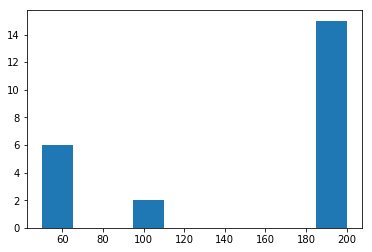

In [5]:
plt.hist(real_data['Pressure'])
plt.show()

Pourcentage des essais ayant une pressions différente a 200 psi:

In [6]:
round(len(real_data[real_data.Pressure != 200]) * 100 / len(real_data))

35

~~Très bien, nous avons une variabilité de température importante mais
la pression est quasiment toujours égale à 200, ce qui devrait
simplifier l'analyse.~~

**Avec l'ensemble des données 35% des essais ont une pression différente de 200 psi. Se serai un erreur de négliger l'analyse de son impact.**

Comment la fréquence d'échecs varie-t-elle avec la température ?

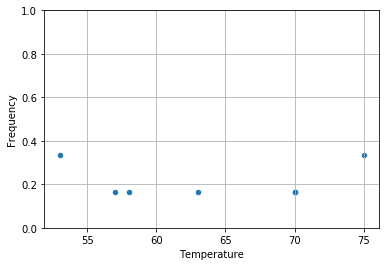

In [7]:
%matplotlib inline


data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

À première vue, ce n'est pas flagrant mais bon, essayons quand même
d'estimer l'impact de la température $t$ sur la probabilité de
dysfonctionnements d'un joint. 


**Voici le vrai plot avec toute les données :**

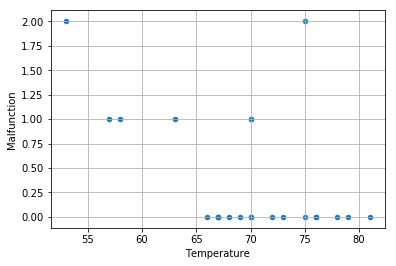

In [11]:
real_data.plot(x="Temperature", y="Malfunction", kind="scatter")
plt.grid(True)

**Là on peut deviner un impact de la température malgré un outlier à 2 Malfunction pour 75°F**

## Estimation de l'influence de la température

Supposons que chacun des 6 joints toriques est endommagé avec la même
probabilité et indépendamment des autres et que cette probabilité ne
dépend que de la température. Si on note $p(t)$ cette probabilité, le
nombre de joints $D$ dysfonctionnant lorsque l'on effectue le vol à
température $t$ suit une loi binomiale de paramètre $n=6$ et
$p=p(t)$. Pour relier $p(t)$ à $t$, on va donc effectuer une
régression logistique.

In [12]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                    7
Model:                            GLM   Df Residuals:                        5
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2.5250
Date:                Wed, 07 Dec 2022   Deviance:                      0.22231
Time:                        15:54:33   Pearson chi2:                    0.236
No. Iterations:                     4   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3895      7.828     -0.178      0.859     -16.732      13.953
Temperature     0.0014      0.122      0.012      0.991      -0.238       0.240
===============================================================================
"""

L'estimateur le plus probable du paramètre de température est 0.0014
et l'erreur standard de cet estimateur est de 0.122, autrement dit on
ne peut pas distinguer d'impact particulier et il faut prendre nos
estimations avec des pincettes.


In [14]:
real_data["Success"] = real_data.Count-real_data.Malfunction
real_data["Intercept"]=1

real_logmodel=sm.GLM(real_data['MalfunctionHappen'], real_data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.logit)).fit()

real_logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      MalfunctionHappen   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10.158
Date:                Wed, 07 Dec 2022   Deviance:                       20.315
Time:                        15:54:51   Pearson chi2:                     23.2
No. Iterations:                     5   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020
===============================================================================
"""

## Estimation de la probabilité de dysfonctionnant des joints toriques
La température prévue le jour du décollage est de 31°F. Essayons
d'estimer la probabilité de dysfonctionnement des joints toriques à
cette température à partir du modèle que nous venons de construire:


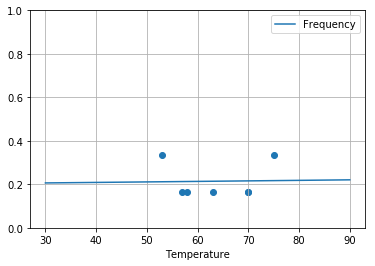

In [15]:
%matplotlib inline
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

Comme on pouvait s'attendre au vu des données initiales, la
température n'a pas d'impact notable sur la probabilité d'échec des
joints toriques. Elle sera d'environ 0.2, comme dans les essais
précédents où nous il y a eu défaillance d'au moins un joint. Revenons
à l'ensemble des données initiales pour estimer la probabilité de
défaillance d'un joint:


In [16]:
data = pd.read_csv("shuttle.csv")
print(np.sum(data.Malfunction)/np.sum(data.Count))

0.06521739130434782


Cette probabilité est donc d'environ $p=0.065$, sachant qu'il existe
un joint primaire un joint secondaire sur chacune des trois parties du
lançeur, la probabilité de défaillance des deux joints d'un lançeur
est de $p^2 \approx 0.00425$. La probabilité de défaillance d'un des
lançeur est donc de $1-(1-p^2)^3 \approx 1.2%$.  Ça serait vraiment
pas de chance... Tout est sous contrôle, le décollage peut donc avoir
lieu demain comme prévu.

Seulement, le lendemain, la navette Challenger explosera et emportera
avec elle ses sept membres d'équipages. L'opinion publique est
fortement touchée et lors de l'enquête qui suivra, la fiabilité des
joints toriques sera directement mise en cause. Au delà des problèmes
de communication interne à la NASA qui sont pour beaucoup dans ce
fiasco, l'analyse précédente comporte (au moins) un petit
problème... Saurez-vous le trouver ? Vous êtes libre de modifier cette
analyse et de regarder ce jeu de données sous tous les angles afin
d'expliquer ce qui ne va pas.

## Et maintenant la vrai probabilité en fonction de la température

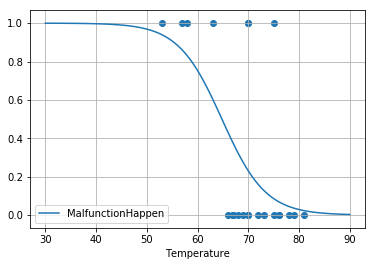

In [18]:
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['MalfunctionHappen'] = real_logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="MalfunctionHappen",kind="line")
plt.scatter(x=real_data["Temperature"],y=real_data["MalfunctionHappen"])
plt.grid(True)

In [19]:
real_logmodel.predict([1, 31])

array([0.99960878])

La probabilité qu'un incident arrive à 31°F est tellement haute que s'en est ridicule.

In [22]:
print("Probabilité qu'au moins un joint lache:", np.sum(real_data.MalfunctionHappen)/len(real_data))
print("Probabilité que 2 joint lache:", (np.sum(real_data.MalfunctionHappen)/len(real_data)) ** 2)

Probabilité qu'au moins un joint lache: 0.30434782608695654
Probabilité que 2 joint lache: 0.09262759924385634


Même sans prendre en compte la température, je trouve ça beaucoup trop élevé pour lancer une fusée avec des êtres humains à l'intérieur.